<a href="https://colab.research.google.com/github/yasharmaster/image-segmentation-demo/blob/master/VGG_Segmentation_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VGG Segmentation Demo
https://github.com/mzaradzki/neuralnets/tree/master/vgg_segmentation_keras

In [6]:
!wget https://raw.githubusercontent.com/mzaradzki/neuralnets/master/vgg_segmentation_keras/fcn_keras2.py

--2019-04-01 07:00:28--  https://raw.githubusercontent.com/mzaradzki/neuralnets/master/vgg_segmentation_keras/fcn_keras2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5266 (5.1K) [text/plain]
Saving to: ‘fcn_keras2.py’

fcn_keras2.py       100%[===================>]   5.14K  --.-KB/s    in 0s      

2019-04-01 07:00:28 (41.5 MB/s) - ‘fcn_keras2.py’ saved [5266/5266]



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

from scipy.misc import bytescale

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import merge

In [0]:
from fcn_keras2 import fcn32_blank, fcn_32s_to_16s, prediction

In [0]:
image_size = 64*8 # INFO: initially tested with 256, 448, 512

In [11]:
fcn32model = fcn32_blank(image_size)
fcn32model.summary()
fcn16model = fcn_32s_to_16s(fcn32model)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 256, 256, 128)     147584    
_________________________________________________________________
max_

In [12]:
# INFO : dummy image array to test the model passes
imarr = np.ones((image_size,image_size, 3))
imarr = np.expand_dims(imarr, axis=0)

#testmdl = Model(fcn32model.input, fcn32model.layers[10].output) # works fine
testmdl = fcn16model # works fine
testmdl.predict(imarr).shape

(1, 512, 512, 21)

In [0]:
if (testmdl.predict(imarr).shape != (1, image_size, image_size, 21)):
    print('WARNING: size mismatch will impact some test cases')

In [14]:
fcn16model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 512, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 512, 512, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 512, 512, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [17]:
!wget http://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat

--2019-04-01 07:06:32--  http://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500215534 (477M) [text/plain]
Saving to: ‘pascal-fcn16s-dag.mat’

pascal-fcn16s-dag.m 100%[===================>] 477.04M  40.6MB/s    in 12s     

2019-04-01 07:06:44 (39.4 MB/s) - ‘pascal-fcn16s-dag.mat’ saved [500215534/500215534]



In [0]:
from scipy.io import loadmat

In [0]:
data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description

In [20]:
l.shape, p.shape, description.shape

((1, 42), (1, 38), (1, 21))

In [21]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [0]:
if False: # inspection of data structure
    print(dir(l[0,31].block[0,0]))
    print(dir(l[0,36].block[0,0]))

In [23]:
for i in range(0, p.shape[1]-1, 2):
    print(i,
          str(p[0,i].name[0]), p[0,i].value.shape,
          str(p[0,i+1].name[0]), p[0,i+1].value.shape)

0 conv1_1_filter (3, 3, 3, 64) conv1_1_bias (64, 1)
2 conv1_2_filter (3, 3, 64, 64) conv1_2_bias (64, 1)
4 conv2_1_filter (3, 3, 64, 128) conv2_1_bias (128, 1)
6 conv2_2_filter (3, 3, 128, 128) conv2_2_bias (128, 1)
8 conv3_1_filter (3, 3, 128, 256) conv3_1_bias (256, 1)
10 conv3_2_filter (3, 3, 256, 256) conv3_2_bias (256, 1)
12 conv3_3_filter (3, 3, 256, 256) conv3_3_bias (256, 1)
14 conv4_1_filter (3, 3, 256, 512) conv4_1_bias (512, 1)
16 conv4_2_filter (3, 3, 512, 512) conv4_2_bias (512, 1)
18 conv4_3_filter (3, 3, 512, 512) conv4_3_bias (512, 1)
20 conv5_1_filter (3, 3, 512, 512) conv5_1_bias (512, 1)
22 conv5_2_filter (3, 3, 512, 512) conv5_2_bias (512, 1)
24 conv5_3_filter (3, 3, 512, 512) conv5_3_bias (512, 1)
26 fc6_filter (7, 7, 512, 4096) fc6_bias (4096, 1)
28 fc7_filter (1, 1, 4096, 4096) fc7_bias (4096, 1)
30 score_fr_filter (1, 1, 4096, 21) score_fr_bias (21, 1)
32 score2_filter (4, 4, 21, 21) score2_bias (21, 1)
34 score_pool4_filter (1, 1, 512, 21) score_pool4_bias (21,

In [24]:
for i in range(l.shape[1]):
    print(i,
          str(l[0,i].name[0]), str(l[0,i].type[0]),
          [str(n[0]) for n in l[0,i].inputs[0,:]],
          [str(n[0]) for n in l[0,i].outputs[0,:]])

0 conv1_1 dagnn.Conv ['data'] ['conv1_1']
1 relu1_1 dagnn.ReLU ['conv1_1'] ['conv1_1x']
2 conv1_2 dagnn.Conv ['conv1_1x'] ['conv1_2']
3 relu1_2 dagnn.ReLU ['conv1_2'] ['conv1_2x']
4 pool1 dagnn.Pooling ['conv1_2x'] ['pool1']
5 conv2_1 dagnn.Conv ['pool1'] ['conv2_1']
6 relu2_1 dagnn.ReLU ['conv2_1'] ['conv2_1x']
7 conv2_2 dagnn.Conv ['conv2_1x'] ['conv2_2']
8 relu2_2 dagnn.ReLU ['conv2_2'] ['conv2_2x']
9 pool2 dagnn.Pooling ['conv2_2x'] ['pool2']
10 conv3_1 dagnn.Conv ['pool2'] ['conv3_1']
11 relu3_1 dagnn.ReLU ['conv3_1'] ['conv3_1x']
12 conv3_2 dagnn.Conv ['conv3_1x'] ['conv3_2']
13 relu3_2 dagnn.ReLU ['conv3_2'] ['conv3_2x']
14 conv3_3 dagnn.Conv ['conv3_2x'] ['conv3_3']
15 relu3_3 dagnn.ReLU ['conv3_3'] ['conv3_3x']
16 pool3 dagnn.Pooling ['conv3_3x'] ['pool3']
17 conv4_1 dagnn.Conv ['pool3'] ['conv4_1']
18 relu4_1 dagnn.ReLU ['conv4_1'] ['conv4_1x']
19 conv4_2 dagnn.Conv ['conv4_1x'] ['conv4_2']
20 relu4_2 dagnn.ReLU ['conv4_2'] ['conv4_2x']
21 conv4_3 dagnn.Conv ['conv4_2x'] ['co

In [0]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [26]:
copy_mat_to_keras(fcn16model)

found :  ('conv1_1', 2)
(3, 3, 3, 64) (3, 3, 3, 64)
found :  ('conv1_2', 3)
(3, 3, 64, 64) (3, 3, 64, 64)
found :  ('conv2_1', 5)
(3, 3, 64, 128) (3, 3, 64, 128)
found :  ('conv2_2', 6)
(3, 3, 128, 128) (3, 3, 128, 128)
found :  ('conv3_1', 8)
(3, 3, 128, 256) (3, 3, 128, 256)
found :  ('conv3_2', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv3_3', 10)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv4_1', 12)
(3, 3, 256, 512) (3, 3, 256, 512)
found :  ('conv4_2', 13)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv4_3', 14)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_1', 16)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_2', 17)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_3', 18)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('fc6', 20)
(7, 7, 512, 4096) (7, 7, 512, 4096)
found :  ('fc7', 21)
(1, 1, 4096, 4096) (1, 1, 4096, 4096)
found :  ('score_fr', 22)
(1, 1, 4096, 21) (1, 1, 4096, 21)
found :  ('score2', 23)
(4, 4, 21, 21) (4, 4, 21, 21)
found :  ('score_pool

In [38]:
from google.colab import files
uploads = files.upload()

Saving photo-1533481038561-73a2e03ad570.jpeg to photo-1533481038561-73a2e03ad570 (1).jpeg


(512, 512, 3)
(1, 512, 512, 21)
(512, 512)
0 background
1 aeroplane
4 boat
6 bus
9 chair
13 horse
15 person
18 sofa
19 train


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


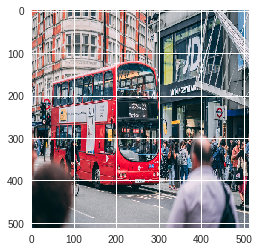

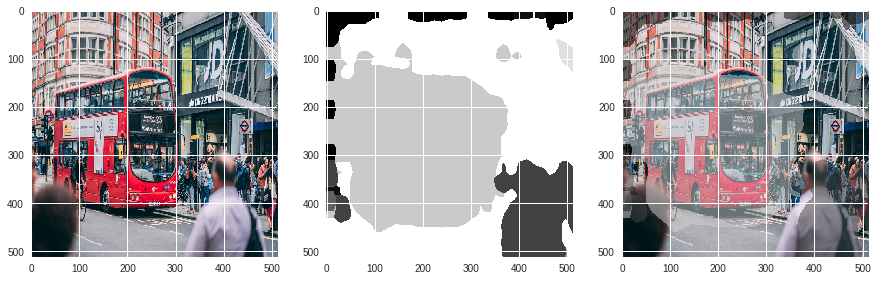

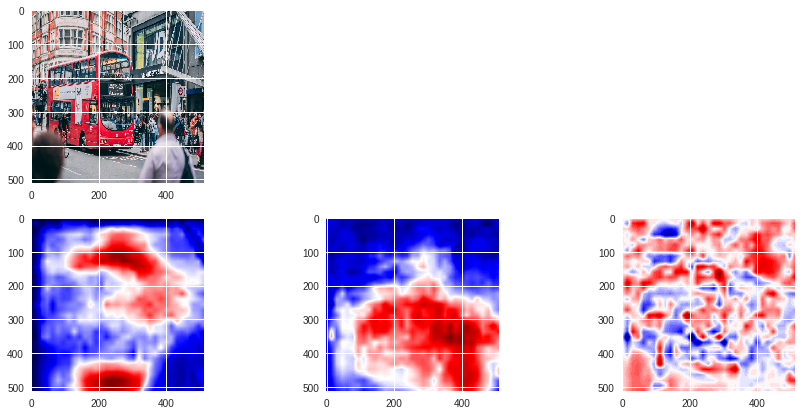

In [41]:
for upload in uploads.keys():
  im = Image.open(upload) 
#   im = im.crop((0,0,319,319))
  im = im.resize((image_size,image_size))
  plt.imshow(np.asarray(im))
  print(np.asarray(im).shape)
  crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
  preds = prediction(fcn16model, crpim, transform=False) # WARNING : transfrom=True requires a code change (dim order)
  #imperson = preds[0,class2index['person'],:,:]
  print(preds.shape)
  imclass = np.argmax(preds, axis=3)[0,:,:]
  print(imclass.shape)
  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1)
  plt.imshow( np.asarray(crpim) )
  plt.subplot(1,3,2)
  plt.imshow( imclass )
  plt.subplot(1,3,3)
  plt.imshow( np.asarray(crpim) )
  masked_imclass = np.ma.masked_where(imclass == 0, imclass)
  #plt.imshow( imclass, alpha=0.5 )
  plt.imshow( masked_imclass, alpha=0.5 )  
  
  # List of dominant classes found in the image
  for c in np.unique(imclass):
      print(c, str(description[0,c][0]))
  
  bspreds = bytescale(preds, low=0, high=255)
  plt.figure(figsize = (15, 7))
  plt.subplot(2,3,1)
  plt.imshow(np.asarray(crpim))
  plt.subplot(2,3,3+1)
  plt.imshow(bspreds[0,:,:,class2index['background']], cmap='seismic')
  plt.subplot(2,3,3+2)
  plt.imshow(bspreds[0,:,:,class2index['person']], cmap='seismic')
  plt.subplot(2,3,3+3)
  plt.imshow(bspreds[0,:,:,class2index['bicycle']], cmap='seismic')

(1, 512, 512, 21)
(512, 512)


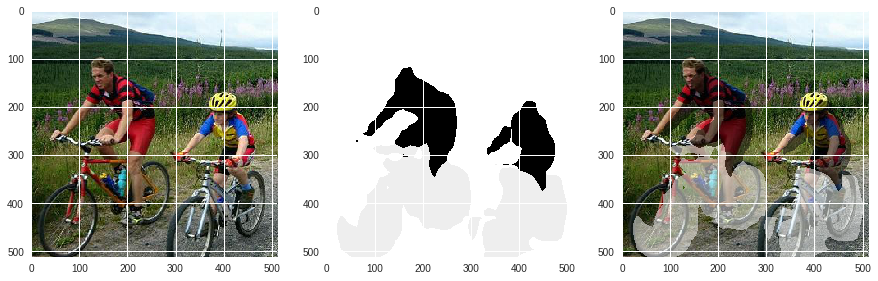

In [31]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )